In [1]:
import os
import random
from datetime import datetime
from pathlib import Path
from typing import Any, Dict, List, Tuple

import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image, ImageDraw
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
from tqdm.auto import tqdm
from transformers import AutoImageProcessor, AutoModel

### Setup:

In [2]:
# Set random seeds for reproducibility
torch.manual_seed(5)

# Set images path
train_dir = Path("../data/BrainTumor/train")
test_dir = Path("../data/BrainTumor/test")
valid_dir = Path("../data/BrainTumor/valid")

# Setup class names
CLASSES_NAMES = ["glioma", "meningioma", "pituitary"]


# Load Dino model and processor
def load_model_and_processor(model_name: str) -> Tuple[AutoModel, AutoImageProcessor]:
    processor = AutoImageProcessor.from_pretrained(model_name, use_fast=True, token=os.getenv("HF_TOKEN"))
    model = AutoModel.from_pretrained(model_name)
    return model, processor


dinov2, dinov2_processor = load_model_and_processor("facebook/dinov2-base")
dinov3, dinov3_processor = load_model_and_processor("facebook/dinov3-vitb16-pretrain-lvd1689m")

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

In [3]:
def create_writer(experiment_name: str, model_name: str, extra: str = None) -> SummaryWriter:
    """Creates a SummaryWriter instance saving to a specific log_dir.

    Args:
        experiment_name (str): Name of experiment.
        model_name (str): Name of model.
        extra (str, optional): Anything extra to add to the directory. Defaults to None.

    Returns:
        torch.utils.tensorboard.writer.SummaryWriter(): Instance of a writer saving to log_dir.
    """

    # Get timestamp of current date (all experiments on certain day live in same folder)
    timestamp = datetime.now().strftime("%Y-%m-%d")

    log_dir = Path("../runs") / timestamp / experiment_name / model_name
    if extra:
        log_dir /= extra

    print(f"[INFO] Created SummaryWriter, saving to: {log_dir}...")

    return SummaryWriter(log_dir=log_dir)

In [4]:
class SemanticSegmentationDataset(Dataset):
    """Dataset for semantic segmentation with polygon annotations"""

    def __init__(self, directory: Path, processor) -> None:
        """
        Args:
            directory: Path to images and labels folder
            processor: Image processor
        """
        super().__init__()
        self.images_dir = directory / "images"
        self.labels_dir = directory / "labels"
        self.processor = processor

        # Get all image files
        self.image_files = list(self.images_dir.glob("*.jpg"))
        self.image_files.sort()

        print(f"Found {len(self.image_files)} images in {self.images_dir}")

    def __len__(self) -> int:
        return len(self.image_files)

    def __getitem__(self, idx) -> Dict[str, Any]:
        img_path = self.image_files[idx]
        image = Image.open(img_path)

        label_path = self.labels_dir / f"{img_path.stem}.txt"
        labels = self._load_labels(label_path)

        # Process image first to get the target size
        processed_image = self.processor(images=image, return_tensors="pt")
        pixel_values = processed_image["pixel_values"].squeeze(0)
        target_size = (pixel_values.shape[1], pixel_values.shape[2])  # (H, W)

        # Create segmentation mask at the target size
        mask = self._create_segmentation_mask(labels, target_size)
        mask_tensor = torch.from_numpy(mask).long()

        return {"pixel_values": pixel_values, "mask": mask_tensor, "image_path": img_path, "original_image": image}

    def _load_labels(self, labels_path: Path) -> List[Dict[str, Any]]:
        """Load labels from text file"""
        labels = []

        with open(labels_path, "r") as f:
            lines = f.readlines()

        for line in lines:
            entries = line.strip().split()
            # Extract class id (first entry)
            class_id = int(entries[0])

            # Extract polygon coordinates (normalized between 0-1)
            coordinates = [float(i) for i in entries[1:]]
            x_coords = coordinates[::2]
            y_coords = coordinates[1::2]

            labels.append({"class_id": class_id, "vertices": list(zip(x_coords, y_coords))})

        return labels

    def _create_segmentation_mask(self, labels: List[Dict[str, Any]], target_size: Tuple[int, int]) -> np.ndarray:
        """Create segmentation mask from polygon vertices"""
        target_height, target_width = target_size
        mask = np.zeros((target_height, target_width), dtype=np.uint8)

        for label in labels:
            class_id = label["class_id"]
            vertices = label["vertices"]

            # Convert normalized coordinates to target size pixel coordinates
            pixel_vertices = [(int(x * target_width), int(y * target_height)) for x, y in vertices]

            # Create polygon mask using PIL at target size
            mask_img = Image.new("L", (target_width, target_height), 0)
            ImageDraw.Draw(mask_img).polygon(pixel_vertices, fill=class_id + 1)  # +1 to avoid background class

            # Convert to numpy and add to main mask
            polygon_mask = np.array(mask_img)
            mask = np.maximum(mask, polygon_mask)

        return mask

In [5]:
train_dataset = SemanticSegmentationDataset(train_dir, processor=dinov2_processor)
train_dataset[0]

Found 2144 images in ../data/BrainTumor/train/images


{'pixel_values': tensor([[[-2.0152, -2.0152, -2.0152,  ..., -1.8782, -1.8953, -1.9124],
          [-1.9980, -1.9980, -1.9980,  ..., -1.9809, -1.9124, -1.8782],
          [-1.9809, -1.9809, -1.9809,  ..., -2.0152, -1.9467, -1.8953],
          ...,
          [-2.0152, -2.0152, -2.0152,  ...,  0.0569,  0.0741, -0.3712],
          [-1.9809, -2.0152, -2.0323,  ..., -0.3712, -0.4054, -0.5596],
          [-2.0323, -2.0152, -1.9980,  ..., -0.5596, -0.5596, -0.7137]],
 
         [[-1.9307, -1.9307, -1.9307,  ..., -1.7906, -1.8081, -1.8256],
          [-1.9132, -1.9132, -1.9132,  ..., -1.8957, -1.8256, -1.7906],
          [-1.8957, -1.8957, -1.8957,  ..., -1.9307, -1.8606, -1.8081],
          ...,
          [-1.9307, -1.9307, -1.9307,  ...,  0.1877,  0.2052, -0.2500],
          [-1.8957, -1.9307, -1.9482,  ..., -0.2500, -0.2850, -0.4426],
          [-1.9482, -1.9307, -1.9132,  ..., -0.4426, -0.4426, -0.6001]],
 
         [[-1.6999, -1.6999, -1.6999,  ..., -1.5604, -1.5779, -1.5953],
          [-

In [6]:
def create_segmentation_dataloaders(
    train_dir: Path, test_dir: Path, valid_dir: Path, processor=None, batch_size: int = 8
) -> Tuple[DataLoader, DataLoader]:
    """Create dataloaders for semantic segmentation"""

    train_dataset = SemanticSegmentationDataset(train_dir, processor=processor)
    test_dataset = SemanticSegmentationDataset(test_dir, processor=processor)
    validation_dataset = SemanticSegmentationDataset(valid_dir, processor=processor)

    def collate_fn(batch) -> Dict[str, Any]:
        """Custom collate function for segmentation"""
        pixel_values = torch.stack([item["pixel_values"] for item in batch])
        masks = torch.stack([item["mask"] for item in batch])
        image_paths = [item["image_path"] for item in batch]
        original_images = [item["original_image"] for item in batch]

        return {
            "pixel_values": pixel_values,
            "masks": masks,
            "image_paths": image_paths,
            "original_images": original_images,
        }

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
    validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

    return train_dataloader, test_dataloader, validation_dataloader

In [7]:
# Create train and test dataloaders
dinov2_train_dataloader, dinov2_test_dataloader, dinov2_validation_dataloader = create_segmentation_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    valid_dir=valid_dir,
    processor=dinov2_processor,
    batch_size=8,
)

dinov3_train_dataloader, dinov3_test_dataloader, dinov3_validation_dataloader = create_segmentation_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    valid_dir=valid_dir,
    processor=dinov3_processor,
    batch_size=8,
)

Found 2144 images in ../data/BrainTumor/train/images
Found 308 images in ../data/BrainTumor/test/images
Found 612 images in ../data/BrainTumor/valid/images
Found 2144 images in ../data/BrainTumor/train/images
Found 308 images in ../data/BrainTumor/test/images
Found 612 images in ../data/BrainTumor/valid/images



=== Visualizing with Overlay ===


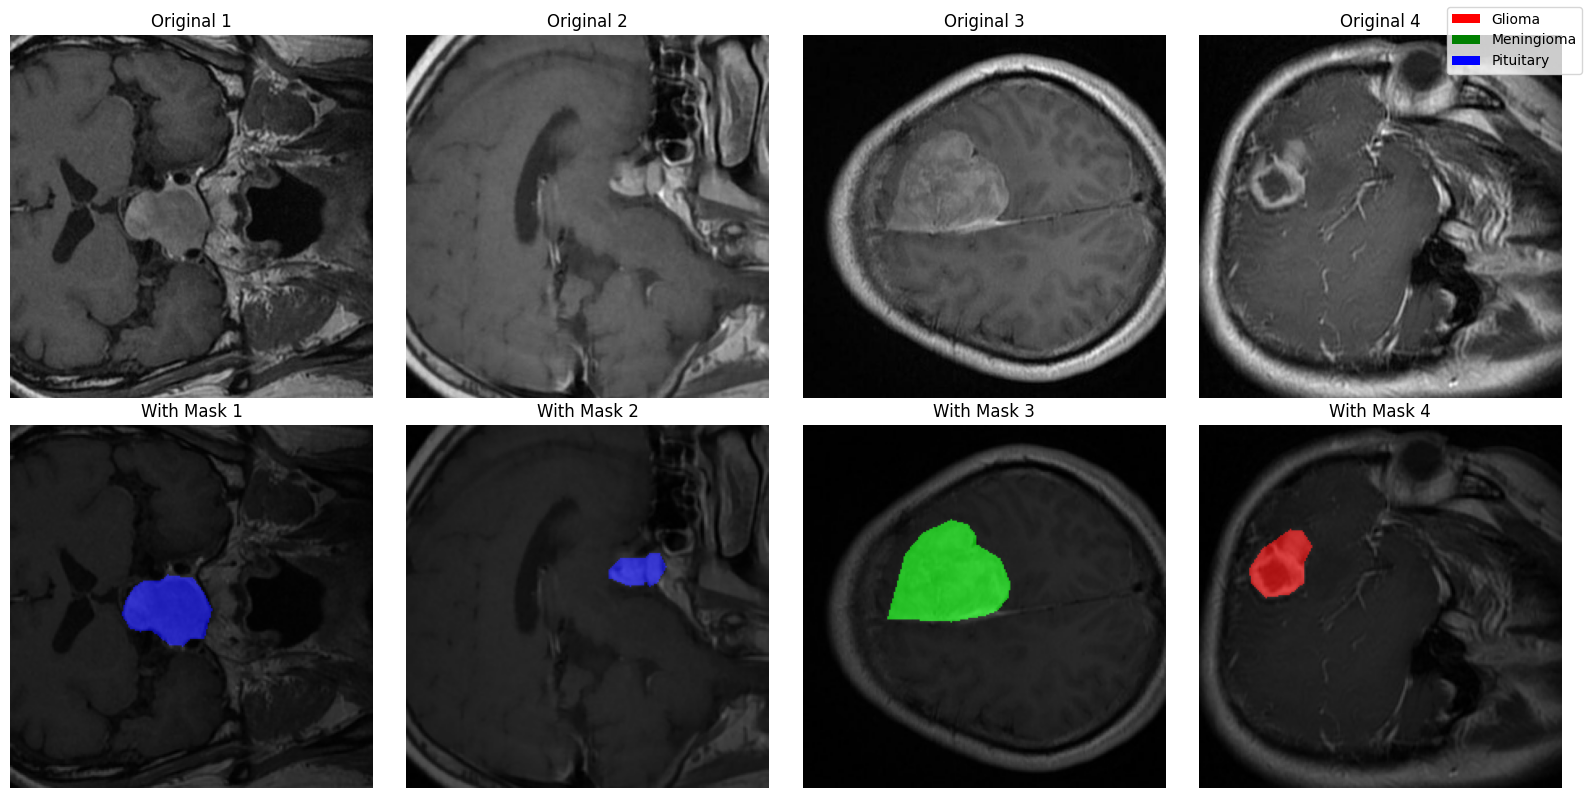

In [8]:
def overlay_mask(image: Image.Image, mask: np.ndarray, alpha=0.5) -> Image.Image:
    """Simple mask overlay on image"""

    # Resize image to match mask size
    img = np.array(image.resize((mask.shape[1], mask.shape[0])))

    # Create colored overlay
    overlay = np.zeros_like(img)
    colors = {1: [255, 0, 0], 2: [0, 255, 0], 3: [0, 0, 255]}  # Red, Green, Blue

    for class_id, color in colors.items():
        overlay[mask == class_id] = color

    # Blend manually
    result = (1 - alpha) * img + alpha * overlay
    return Image.fromarray(result.astype(np.uint8))


def visualize_overlay_batch(dataloader, num_samples: int = 4, alpha: float = 0.5) -> None:
    """Visualize images with overlaid segmentation masks"""

    # Get first batch
    batch = next(iter(dataloader))
    masks = batch["masks"]
    original_images = batch["original_images"]

    # Limit to num_samples
    num_samples = min(num_samples, len(original_images))

    fig, axes = plt.subplots(2, num_samples, figsize=(4 * num_samples, 8))
    if num_samples == 1:
        axes = [axes]
        axes = axes.reshape(2, 1)

    for i in range(num_samples):
        # Top row: Original images
        axes[0, i].imshow(original_images[i])
        axes[0, i].set_title(f"Original {i + 1}")
        axes[0, i].axis("off")

        # Bottom row: Overlaid images
        overlaid_image = overlay_mask(original_images[i], masks[i].numpy(), alpha=alpha)
        axes[1, i].imshow(overlaid_image)
        axes[1, i].set_title(f"With Mask {i + 1}")
        axes[1, i].axis("off")

    # Add legend
    legend_elements = [
        patches.Patch(facecolor="red", label="Glioma"),
        patches.Patch(facecolor="green", label="Meningioma"),
        patches.Patch(facecolor="blue", label="Pituitary"),
    ]
    fig.legend(handles=legend_elements, loc="upper right")

    plt.tight_layout()
    plt.show()


print("\n=== Visualizing with Overlay ===")
visualize_overlay_batch(dinov2_train_dataloader, num_samples=4, alpha=0.6)

## Model Architecture:

In [9]:
class DINOSegmentationHead(nn.Module):
    """Segmentation head for DINO features with optimized memory usage"""

    def __init__(
        self, dino_model, num_classes: int = 4, head_hidden_dim: int = 256, dropout: float = 0.1, image_size: int = 224
    ) -> None:
        """
        Args:
            dino_model: Pre-trained DINO model
            num_classes: Number of segmentation classes (including background)
            head_hidden_dim: DINO head hidden dimension (256 for base model)
            dropout: Dropout rate for the segmentation head
            image_size: Input image size (assumed square)
        """
        super().__init__()
        self.backbone = dino_model
        self.num_classes = num_classes
        self.feature_dim = dino_model.config.hidden_size
        self.head_hidden_dim = head_hidden_dim
        self.dropout = dropout
        self.image_size = image_size

        # Freeze DINO parameters for feature extraction
        for param in self.backbone.parameters():
            param.requires_grad = False

        # Pre-compute patch grid size based on model type
        if self.backbone.config.model_type == "dinov2":
            self.num_patches = 256
            self.patch_length = 16
            self.token_offset = 1  # Skip CLS token
        elif self.backbone.config.model_type == "dinov3_vit":
            self.num_patches = 196
            self.patch_length = 14
            self.token_offset = 5  # Skip CLS token and 4 register tokens
        else:
            raise ValueError(f"Unsupported model type: {self.backbone.config.model_type}")

        # Segmentation head with optimized architecture
        self.segmentation_head = nn.Sequential(
            nn.Conv2d(self.feature_dim, self.head_hidden_dim, kernel_size=3, padding=1),
            nn.BatchNorm2d(self.head_hidden_dim),
            nn.GELU(),
            nn.Dropout(self.dropout),
            nn.Conv2d(self.head_hidden_dim, self.head_hidden_dim // 2, kernel_size=3, padding=1),
            nn.BatchNorm2d(self.head_hidden_dim // 2),
            nn.GELU(),
            nn.Dropout(self.dropout),
            nn.Conv2d(self.head_hidden_dim // 2, num_classes, kernel_size=1),
        )

    def forward(self, pixel_values: torch.Tensor) -> torch.Tensor:
        batch_size = pixel_values.shape[0]

        # Get DINO features efficiently - no gradients needed for frozen backbone
        with torch.no_grad():
            outputs = self.backbone(pixel_values)  # Don't need all hidden states

        # Extract patch embeddings using narrow() for better memory efficiency
        hidden_states = outputs.last_hidden_state  # [B, num_tokens, feature_dim]
        patch_embeddings = hidden_states.narrow(1, self.token_offset, self.num_patches)  # [B, num_patches, feature_dim]
        patch_embeddings = patch_embeddings.transpose(1, 2).contiguous()  # [B, feature_dim, num_patches]
        patch_embeddings = patch_embeddings.view(
            batch_size, self.feature_dim, self.patch_length, self.patch_length
        )  # [B, feature_dim, H, W]

        # Apply segmentation head
        logits = self.segmentation_head(patch_embeddings)

        # Upsample to input resolution with better quality interpolation
        logits = F.interpolate(
            logits,
            size=(self.image_size, self.image_size),
            mode="bilinear",
            align_corners=False,
        )

        return logits

## Custom Loss:

In [10]:
class DiceLoss(nn.Module):
    """Dice Loss for segmentation"""

    def __init__(self, smooth: float = 1e-6) -> None:
        super().__init__()
        self.smooth = smooth

    def forward(self, predictions: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        """
        Args:
            predictions: [B, C, H, W] logits
            targets: [B, H, W] class indices
        """
        # Apply softmax to get probabilities
        predictions = F.softmax(predictions, dim=1)

        # Convert targets to one-hot
        targets_one_hot = F.one_hot(targets, num_classes=predictions.shape[1])  # [B, H, W, C]
        targets_one_hot = targets_one_hot.permute(0, 3, 1, 2).float()  # [B, C, H, W]

        # Use reshape instead of view to handle non-contiguous tensors
        predictions_flat = predictions.reshape(-1)
        targets_flat = targets_one_hot.reshape(-1)

        # Calculate dice
        intersection = (predictions_flat * targets_flat).sum()
        dice = (2.0 * intersection + self.smooth) / (predictions_flat.sum() + targets_flat.sum() + self.smooth)

        return 1 - dice


class CombinedLoss(nn.Module):
    """Combined Cross Entropy + Dice Loss"""

    def __init__(self, ce_weight: float = 0.5, dice_weight: float = 0.5) -> None:
        super().__init__()
        self.ce_weight = ce_weight
        self.dice_weight = dice_weight
        self.ce_loss = nn.CrossEntropyLoss()
        self.dice_loss = DiceLoss()

    def forward(self, predictions: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        ce = self.ce_loss(predictions, targets)
        dice = self.dice_loss(predictions, targets)
        return self.ce_weight * ce + self.dice_weight * dice


def calculate_dice_score(predictions: torch.Tensor, targets: torch.Tensor, num_classes: int = 4) -> Dict[str, float]:
    """Calculate Dice score per class"""
    predictions = torch.argmax(predictions, dim=1)
    dice_scores = {}

    for class_id in range(num_classes):
        pred_mask = (predictions == class_id).float()
        target_mask = (targets == class_id).float()

        intersection = (pred_mask * target_mask).sum()
        union = pred_mask.sum() + target_mask.sum()

        if union > 0:
            dice = (2.0 * intersection) / union
            dice_value = dice.item()
        else:
            dice_value = 1.0 if pred_mask.sum() == 0 else 0.0

        class_name = ["background", "glioma", "meningioma", "pituitary"][class_id]
        dice_scores[f"dice_{class_name}"] = dice_value

    dice_scores["dice_mean"] = np.mean(list(dice_scores.values()))
    return dice_scores


In [11]:
def wrap_model(model: nn.Module, device: torch.device) -> Tuple:
    """Wrap model with segmentation head"""
    torch.manual_seed(5)
    wrapped_model = DINOSegmentationHead(model).to(device)

    model_criterion = CombinedLoss(ce_weight=0.4, dice_weight=0.6)
    model_optimizer = torch.optim.Adam(wrapped_model.parameters(), lr=1e-4)
    model_scheduler = ReduceLROnPlateau(model_optimizer, mode="min", factor=0.5, patience=3)

    return wrapped_model, model_criterion, model_optimizer, model_scheduler

In [12]:
# Device agnostic code
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using device: {device}")

# Wrap models in segmentation heads
dinov2_segmentation_model, dinov2_criterion, dinov2_optimizer, dinov2_scheduler = wrap_model(dinov2, device)
dinov3_segmentation_model, dinov3_criterion, dinov3_optimizer, dinov3_scheduler = wrap_model(dinov3, device)

# Define number of classes
num_classes = len(CLASSES_NAMES) + 1  # +1 for background
print(f"Number of classes: {num_classes}")

Using device: mps
Number of classes: 4


## Train Loop:

In [13]:
# Training Functions
def train_epoch(
    model: nn.Module,
    dataloader: DataLoader,
    criterion: nn.Module,
    optimizer: torch.optim.Optimizer,
    device: torch.device,
) -> Tuple[float, Dict[str, float]]:
    """Train for one epoch"""
    model.train()
    total_loss = 0
    all_dice_scores = []

    for batch in dataloader:
        pixel_values = batch["pixel_values"].to(device)
        masks = batch["masks"].to(device)

        optimizer.zero_grad()

        # Forward pass
        logits = model(pixel_values)
        loss = criterion(logits, masks)

        # Backward pass
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Calculate metrics
        with torch.inference_mode():
            dice_scores = calculate_dice_score(logits, masks)
            all_dice_scores.append(dice_scores)

    # Average metrics
    avg_dice = {}
    for key in all_dice_scores[0].keys():
        avg_dice[key] = np.mean([d[key] for d in all_dice_scores])

    avg_loss = total_loss / len(dataloader)

    return avg_loss, avg_dice


def test_epoch(
    model: nn.Module, dataloader: DataLoader, criterion: nn.Module, device: torch.device
) -> Tuple[float, Dict[str, float]]:
    """Validate for one epoch"""
    model.eval()
    total_loss = 0
    all_dice_scores = []

    with torch.inference_mode():
        for batch in dataloader:
            pixel_values = batch["pixel_values"].to(device)
            masks = batch["masks"].to(device)

            logits = model(pixel_values)
            loss = criterion(logits, masks)

            total_loss += loss.item()

            # Calculate metrics
            dice_scores = calculate_dice_score(logits, masks)
            all_dice_scores.append(dice_scores)

    # Average metrics
    avg_dice = {}
    for key in all_dice_scores[0].keys():
        avg_dice[key] = np.mean([d[key] for d in all_dice_scores])

    avg_loss = total_loss / len(dataloader)

    return avg_loss, avg_dice


In [14]:
def train_segmentation_model(
    model: nn.Module,
    train_dataloader: DataLoader,
    test_dataloader: DataLoader,
    criterion: nn.Module,
    optimizer: torch.optim.Optimizer,
    scheduler: torch.optim.lr_scheduler._LRScheduler,
    device: torch.device,
    writer: SummaryWriter,
    num_epochs: int = 5,
    model_name: str = "segmentation_model",
) -> Dict[str, Any]:
    """
    Reusable training function for segmentation models

    Args:
        model: The segmentation model to train
        train_dataloader: Training data loader
        test_dataloader: Test/validation data loader
        criterion: Loss function
        optimizer: Optimizer
        scheduler: Learning rate scheduler
        device: Device to train on
        writer: TensorBoard SummaryWriter instance
        num_epochs: Number of epochs to train
        model_name: Name for saving the best model

    Returns:
        Dictionary containing training history and best performance
    """
    torch.manual_seed(5)

    # Training history
    history = {
        "train_losses": [],
        "test_losses": [],
        "train_dice_scores": [],
        "test_dice_scores": [],
        "best_test_dice": 0.0,
        "best_epoch": 0,
    }

    best_test_dice = 0

    print(f"Starting training for {num_epochs} epochs...")
    print(f"Device: {device}")
    print(f"Model: {model_name}")
    print("-" * 60)

    for epoch in tqdm(range(num_epochs), desc="Training Progress"):
        print(f"\nEpoch {epoch + 1}/{num_epochs}")
        print("-" * 40)

        # Train
        train_loss, train_dice = train_epoch(model, train_dataloader, criterion, optimizer, device)
        history["train_losses"].append(train_loss)
        history["train_dice_scores"].append(train_dice["dice_mean"])

        # Test/Validate
        test_loss, test_dice = test_epoch(model, test_dataloader, criterion, device)
        history["test_losses"].append(test_loss)
        history["test_dice_scores"].append(test_dice["dice_mean"])

        # Step scheduler
        scheduler.step(test_loss)

        print(f"Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")
        print(f"Train Dice: {train_dice['dice_mean']:.4f}, Test Dice: {test_dice['dice_mean']:.4f}")
        print(
            f"Per-class Dice - Glioma: {test_dice['dice_glioma']:.3f}, "
            f"Meningioma: {test_dice['dice_meningioma']:.3f}, "
            f"Pituitary: {test_dice['dice_pituitary']:.3f}"
        )

        # Save best model
        if test_dice["dice_mean"] > best_test_dice:
            best_test_dice = test_dice["dice_mean"]
            history["best_test_dice"] = best_test_dice
            history["best_epoch"] = epoch + 1

            model_path = f"../models/{model_name}.pth"
            torch.save(model.state_dict(), model_path)

            print(f"New best model saved with Dice: {best_test_dice:.4f}")

        # Log training and test metrics to TensorBoard
        writer.add_scalars(main_tag="loss", tag_scalar_dict={"train": train_loss, "test": test_loss}, global_step=epoch)
        writer.add_scalars(
            main_tag="dice_score",
            tag_scalar_dict={
                "train": train_dice["dice_mean"],
                "train_glioma": train_dice["dice_glioma"],
                "train_meningioma": train_dice["dice_meningioma"],
                "train_pituitary": train_dice["dice_pituitary"],
                "test": test_dice["dice_mean"],
                "test_glioma": test_dice["dice_glioma"],
                "test_meningioma": test_dice["dice_meningioma"],
                "test_pituitary": test_dice["dice_pituitary"],
            },
            global_step=epoch,
        )

        # Close the writer
        writer.close()

    print("\n" + "=" * 60)
    print("✅ Training completed!")
    print(f"🎯 Best test Dice score: {history['best_test_dice']:.4f} (Epoch {history['best_epoch']})")
    print("=" * 60)

    return history


def plot_training_history(history: Dict[str, Any], title: str = "Training History") -> None:
    """Plot training curves from history dictionary"""

    plt.figure(figsize=(15, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(history["train_losses"], label="Train Loss", marker="o")
    plt.plot(history["test_losses"], label="Test Loss", marker="s")
    plt.title("Training and Test Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

    # Dice score plot
    plt.subplot(1, 2, 2)
    plt.plot(history["train_dice_scores"], label="Train Dice", marker="o")
    plt.plot(history["test_dice_scores"], label="Test Dice", marker="s")
    plt.title("Training and Test Dice Score")
    plt.xlabel("Epoch")
    plt.ylabel("Dice Score")
    plt.legend()
    plt.grid(True)

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

[INFO] Created SummaryWriter, saving to: ../runs/2025-09-11/Baseline_Segmentation/dinov2/6_epochs...
🚀 Training dinov2 model...
Starting training for 6 epochs...
Device: mps
Model: dinov2_segmentation
------------------------------------------------------------


Training Progress:   0%|          | 0/6 [00:00<?, ?it/s]


Epoch 1/6
----------------------------------------
Train Loss: 0.5732, Test Loss: 0.2975
Train Dice: 0.4666, Test Dice: 0.6483
Per-class Dice - Glioma: 0.522, Meningioma: 0.470, Pituitary: 0.616
New best model saved with Dice: 0.6483

Epoch 2/6
----------------------------------------
Train Loss: 0.1908, Test Loss: 0.1166
Train Dice: 0.6577, Test Dice: 0.7810
Per-class Dice - Glioma: 0.615, Meningioma: 0.780, Pituitary: 0.738
New best model saved with Dice: 0.7810

Epoch 3/6
----------------------------------------
Train Loss: 0.0847, Test Loss: 0.0656
Train Dice: 0.7173, Test Dice: 0.8428
Per-class Dice - Glioma: 0.769, Meningioma: 0.828, Pituitary: 0.783
New best model saved with Dice: 0.8428

Epoch 4/6
----------------------------------------
Train Loss: 0.0535, Test Loss: 0.0484
Train Dice: 0.7695, Test Dice: 0.8567
Per-class Dice - Glioma: 0.793, Meningioma: 0.842, Pituitary: 0.800
New best model saved with Dice: 0.8567

Epoch 5/6
----------------------------------------
Train Lo

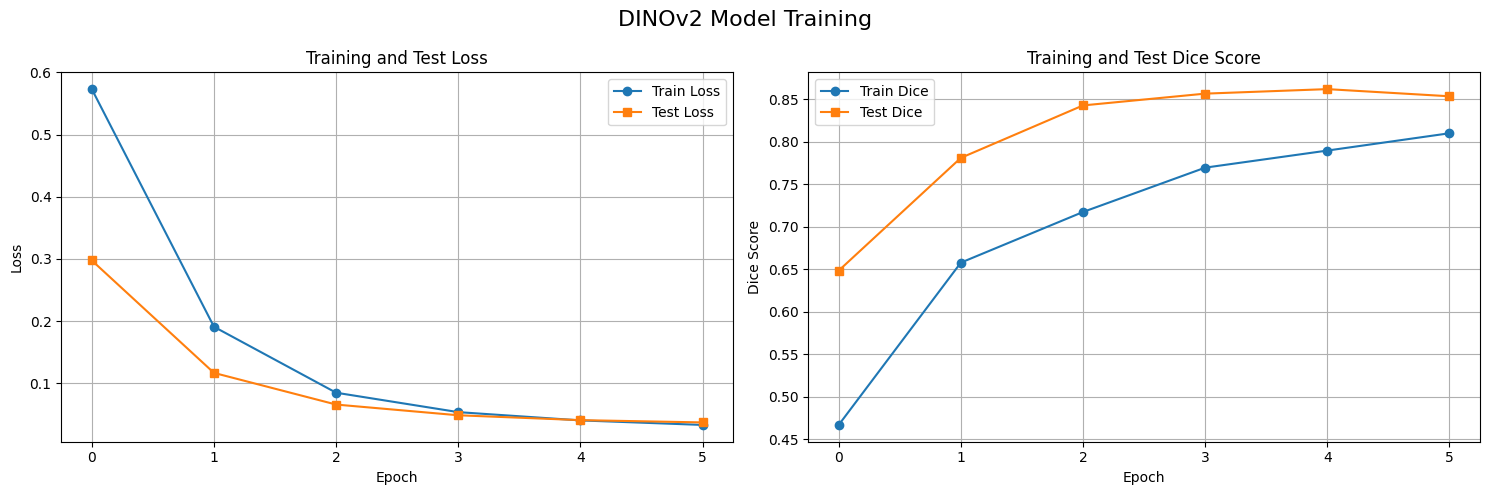

In [15]:
# Train dinov2 model
dinov2_writer = create_writer(experiment_name="Baseline_Segmentation", model_name="dinov2", extra="6_epochs")

print("🚀 Training dinov2 model...")
dinov2_history = train_segmentation_model(
    model=dinov2_segmentation_model,
    train_dataloader=dinov2_train_dataloader,
    test_dataloader=dinov2_test_dataloader,
    criterion=dinov2_criterion,
    optimizer=dinov2_optimizer,
    scheduler=dinov2_scheduler,
    device=device,
    writer=dinov2_writer,
    num_epochs=6,
    model_name="dinov2_segmentation",
)

# Plot results
plot_training_history(dinov2_history, "DINOv2 Model Training")

[INFO] Created SummaryWriter, saving to: ../runs/2025-09-11/Baseline_Segmentation/dinov3/6_epochs...
🚀 Training dinov3 model...
Starting training for 6 epochs...
Device: mps
Model: dinov3_segmentation
------------------------------------------------------------


Training Progress:   0%|          | 0/6 [00:00<?, ?it/s]


Epoch 1/6
----------------------------------------
Train Loss: 0.5825, Test Loss: 0.2971
Train Dice: 0.4524, Test Dice: 0.6277
Per-class Dice - Glioma: 0.613, Meningioma: 0.495, Pituitary: 0.417
New best model saved with Dice: 0.6277

Epoch 2/6
----------------------------------------
Train Loss: 0.1898, Test Loss: 0.1235
Train Dice: 0.6508, Test Dice: 0.7789
Per-class Dice - Glioma: 0.531, Meningioma: 0.823, Pituitary: 0.771
New best model saved with Dice: 0.7789

Epoch 3/6
----------------------------------------
Train Loss: 0.0862, Test Loss: 0.0660
Train Dice: 0.7112, Test Dice: 0.8339
Per-class Dice - Glioma: 0.737, Meningioma: 0.822, Pituitary: 0.785
New best model saved with Dice: 0.8339

Epoch 4/6
----------------------------------------
Train Loss: 0.0552, Test Loss: 0.0494
Train Dice: 0.7527, Test Dice: 0.8373
Per-class Dice - Glioma: 0.731, Meningioma: 0.838, Pituitary: 0.789
New best model saved with Dice: 0.8373

Epoch 5/6
----------------------------------------
Train Lo

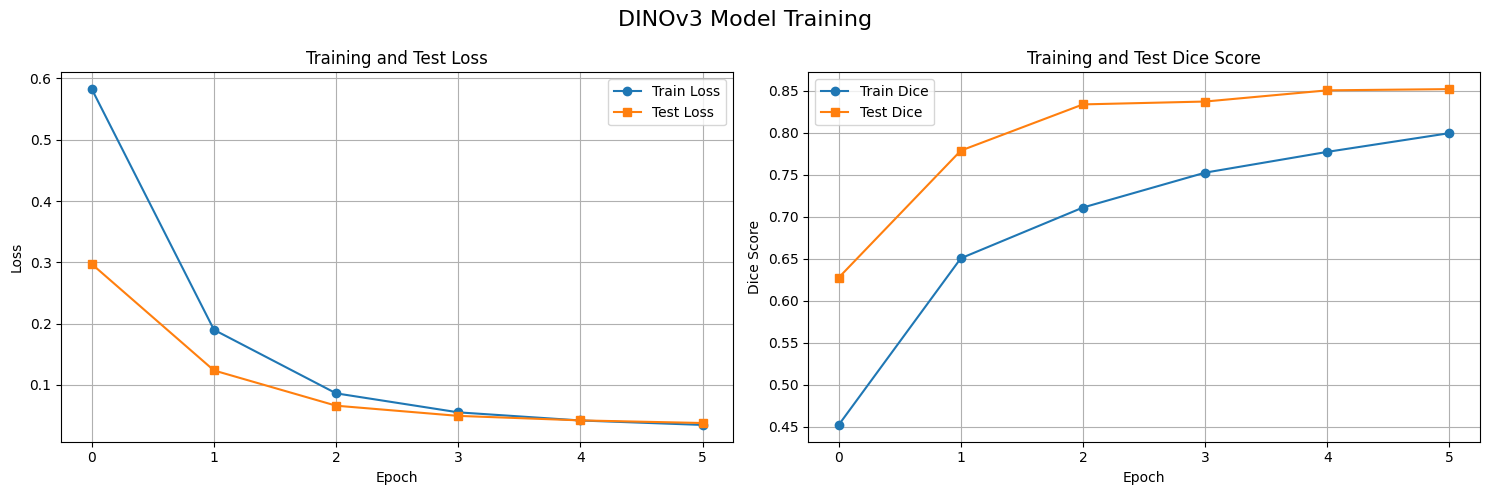

In [16]:
# Train dinov3 model
dinov3_writer = create_writer(experiment_name="Baseline_Segmentation", model_name="dinov3", extra="6_epochs")

print("🚀 Training dinov3 model...")
dinov3_history = train_segmentation_model(
    model=dinov3_segmentation_model,
    train_dataloader=dinov3_train_dataloader,
    test_dataloader=dinov3_test_dataloader,
    criterion=dinov3_criterion,
    optimizer=dinov3_optimizer,
    scheduler=dinov3_scheduler,
    writer=dinov3_writer,
    device=device,
    num_epochs=6,
    model_name="dinov3_segmentation",
)

# Plot results
plot_training_history(dinov3_history, "DINOv3 Model Training")


📊 MODEL COMPARISON
Baseline Model:
  🎯 Best Dice: 0.8620 (Epoch 5)
  📉 Final Loss: 0.0369

Improved Model:
  🎯 Best Dice: 0.8521 (Epoch 6)
  📉 Final Loss: 0.0378

📈 Improvement: -0.0099 (-1.1%)


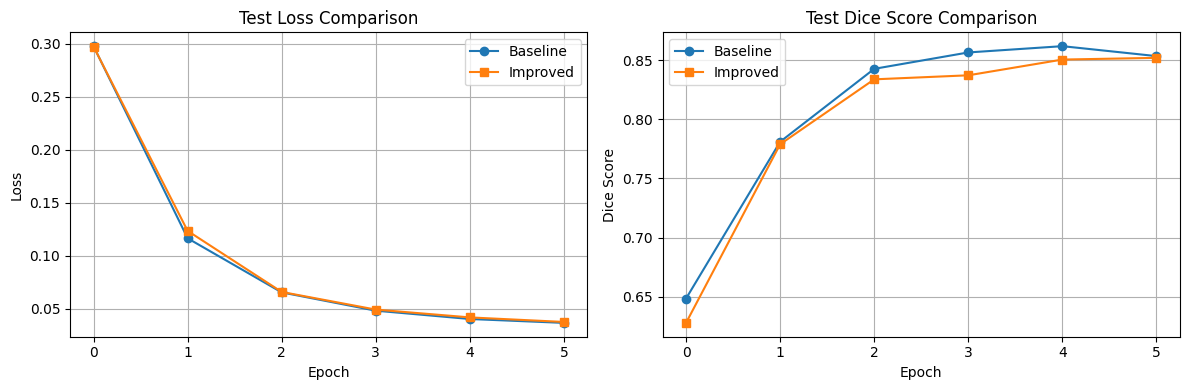

In [17]:
# Compare models
def compare_models(baseline_history, improved_history) -> None:
    """Compare training histories of two models"""

    print("\n" + "=" * 60)
    print("📊 MODEL COMPARISON")
    print("=" * 60)
    print("Baseline Model:")
    print(f"  🎯 Best Dice: {baseline_history['best_test_dice']:.4f} (Epoch {baseline_history['best_epoch']})")
    print(f"  📉 Final Loss: {baseline_history['test_losses'][-1]:.4f}")

    print("\nImproved Model:")
    print(f"  🎯 Best Dice: {improved_history['best_test_dice']:.4f} (Epoch {improved_history['best_epoch']})")
    print(f"  📉 Final Loss: {improved_history['test_losses'][-1]:.4f}")

    improvement = improved_history["best_test_dice"] - baseline_history["best_test_dice"]
    print(f"\n📈 Improvement: {improvement:+.4f} ({improvement / baseline_history['best_test_dice'] * 100:+.1f}%)")
    print("=" * 60)

    # Side-by-side plot
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(baseline_history["test_losses"], label="Baseline", marker="o")
    plt.plot(improved_history["test_losses"], label="Improved", marker="s")
    plt.title("Test Loss Comparison")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(baseline_history["test_dice_scores"], label="Baseline", marker="o")
    plt.plot(improved_history["test_dice_scores"], label="Improved", marker="s")
    plt.title("Test Dice Score Comparison")
    plt.xlabel("Epoch")
    plt.ylabel("Dice Score")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


# Compare the models
compare_models(dinov2_history, dinov3_history)

In [18]:
def evaluate_on_validation(model, validation_dataloader, criterion, device):
    """
    Comprehensive evaluation on validation dataset

    Args:
        model: Trained segmentation model
        validation_dataloader: DataLoader for validation set
        criterion: Loss function
        device: Device to run on
        save_examples: Whether to save prediction examples

    Returns:
        Dict with comprehensive metrics
    """
    model.eval()
    total_loss = 0
    all_dice_scores = []

    print("🔍 Evaluating on validation dataset...")

    with torch.inference_mode():
        for batch in tqdm(validation_dataloader, desc="Validation"):
            pixel_values = batch["pixel_values"].to(device)
            masks = batch["masks"].to(device)

            # Forward pass
            logits = model(pixel_values)
            loss = criterion(logits, masks)
            total_loss += loss.item()

            # Calculate metrics
            dice_scores = calculate_dice_score(logits, masks)
            all_dice_scores.append(dice_scores)

    # Calculate average metrics
    avg_loss = total_loss / len(validation_dataloader)

    # Aggregate dice scores
    final_dice = {}
    for key in all_dice_scores[0].keys():
        scores = [d[key] for d in all_dice_scores]
        final_dice[key] = {"mean": np.mean(scores), "std": np.std(scores), "min": np.min(scores), "max": np.max(scores)}

    # Print comprehensive results
    print("\n" + "=" * 60)
    print("🎯 VALIDATION RESULTS")
    print("=" * 60)
    print(f"📊 Average Loss: {avg_loss:.4f}")
    print(f"🎲 Overall Dice Score: {final_dice['dice_mean']['mean']:.4f} ± {final_dice['dice_mean']['std']:.4f}")
    print("\n📋 Per-Class Results:")

    class_names = ["background", "glioma", "meningioma", "pituitary"]
    for i, class_name in enumerate(class_names):
        dice_key = f"dice_{class_name}"
        if dice_key in final_dice:
            stats = final_dice[dice_key]
            print(
                f"  {class_name.capitalize():12}: {stats['mean']:.3f} ± {stats['std']:.3f} "
                f"(min: {stats['min']:.3f}, max: {stats['max']:.3f})"
            )

    print("=" * 60)

    return {
        "avg_loss": avg_loss,
        "dice_scores": final_dice,
    }


def visualize_validation_predictions_with_overlay(model, validation_dataloader, device, max_examples=6, alpha=0.6):
    """Visualize validation predictions with overlay masks using random samples from entire dataset"""

    model.eval()

    # Get the dataset from the dataloader
    dataset = validation_dataloader.dataset
    dataset_size = len(dataset)

    # Randomly sample indices from the entire dataset
    random_indices = random.sample(range(dataset_size), min(max_examples, dataset_size))

    prediction_examples = []

    print(f"📊 Randomly sampling {len(random_indices)} examples from {dataset_size} validation images...")

    with torch.inference_mode():
        for idx in random_indices:
            # Get single sample from dataset
            sample = dataset[idx]

            # Prepare batch-like input (add batch dimension)
            pixel_values = sample["pixel_values"].unsqueeze(0).to(device)  # [1, C, H, W]
            mask = sample["mask"]  # [H, W]
            original_image = sample["original_image"]

            # Forward pass
            logits = model(pixel_values)
            prediction = torch.argmax(logits, dim=1).squeeze(0)  # Remove batch dimension

            # Calculate dice scores
            dice_scores = calculate_dice_score(logits, mask.unsqueeze(0).to(device))  # Add batch dim for calculation

            prediction_examples.append(
                {
                    "original_image": original_image,
                    "ground_truth": mask.cpu().numpy(),
                    "prediction": prediction.cpu().numpy(),
                    "dice_scores": dice_scores,
                    "dataset_index": idx,
                }
            )

    # Visualize with overlays
    num_examples = len(prediction_examples)
    fig, axes = plt.subplots(2, num_examples, figsize=(4 * num_examples, 8))

    if num_examples == 1:
        axes = axes.reshape(2, 1)

    for i in range(num_examples):
        example = prediction_examples[i]
        original_image = example["original_image"]
        ground_truth = example["ground_truth"]
        prediction = example["prediction"]
        dice_mean = example["dice_scores"]["dice_mean"]
        dataset_idx = example["dataset_index"]

        # Top row: Ground truth overlay
        gt_overlay = overlay_mask(original_image, ground_truth, alpha=alpha)
        axes[0, i].imshow(gt_overlay)
        axes[0, i].set_title(f"Ground Truth {i + 1}\n(Dataset idx: {dataset_idx})")
        axes[0, i].axis("off")

        # Bottom row: Prediction overlay
        pred_overlay = overlay_mask(original_image, prediction, alpha=alpha)
        axes[1, i].imshow(pred_overlay)
        axes[1, i].set_title(f"Prediction {i + 1}\nDice: {dice_mean:.3f}")
        axes[1, i].axis("off")

    # Add legend
    legend_elements = [
        patches.Patch(facecolor="red", label="Glioma"),
        patches.Patch(facecolor="green", label="Meningioma"),
        patches.Patch(facecolor="blue", label="Pituitary"),
    ]
    fig.legend(handles=legend_elements, loc="upper right")

    print("Random Validation Samples: Ground Truth vs Prediction Overlays")
    plt.tight_layout()
    plt.show()

    return prediction_examples


In [25]:
# Run comprehensive validation evaluation
print("🚀 Starting validation evaluation...")
validation_results = evaluate_on_validation(
    model=dinov2_segmentation_model,
    validation_dataloader=dinov2_validation_dataloader,
    criterion=dinov2_criterion,
    device=device,
)

🚀 Starting validation evaluation...
🔍 Evaluating on validation dataset...


Validation:   0%|          | 0/77 [00:00<?, ?it/s]


🎯 VALIDATION RESULTS
📊 Average Loss: 0.0354
🎲 Overall Dice Score: 0.8096 ± 0.1561

📋 Per-Class Results:
  Background  : 0.993 ± 0.004 (min: 0.982, max: 0.998)
  Glioma      : 0.737 ± 0.296 (min: 0.000, max: 1.000)
  Meningioma  : 0.792 ± 0.280 (min: 0.000, max: 1.000)
  Pituitary   : 0.716 ± 0.384 (min: 0.000, max: 1.000)


In [30]:
# Run comprehensive validation evaluation
print("🚀 Starting validation evaluation...")
validation_results = evaluate_on_validation(
    model=dinov3_segmentation_model,
    validation_dataloader=dinov3_validation_dataloader,
    criterion=dinov3_criterion,
    device=device,
)

🚀 Starting validation evaluation...
🔍 Evaluating on validation dataset...


Validation:   0%|          | 0/77 [00:00<?, ?it/s]


🎯 VALIDATION RESULTS
📊 Average Loss: 0.0363
🎲 Overall Dice Score: 0.8433 ± 0.1227

📋 Per-Class Results:
  Background  : 0.992 ± 0.004 (min: 0.979, max: 0.998)
  Glioma      : 0.740 ± 0.284 (min: 0.000, max: 1.000)
  Meningioma  : 0.789 ± 0.291 (min: 0.000, max: 1.000)
  Pituitary   : 0.853 ± 0.248 (min: 0.000, max: 1.000)


📊 Randomly sampling 6 examples from 612 validation images...
Random Validation Samples: Ground Truth vs Prediction Overlays


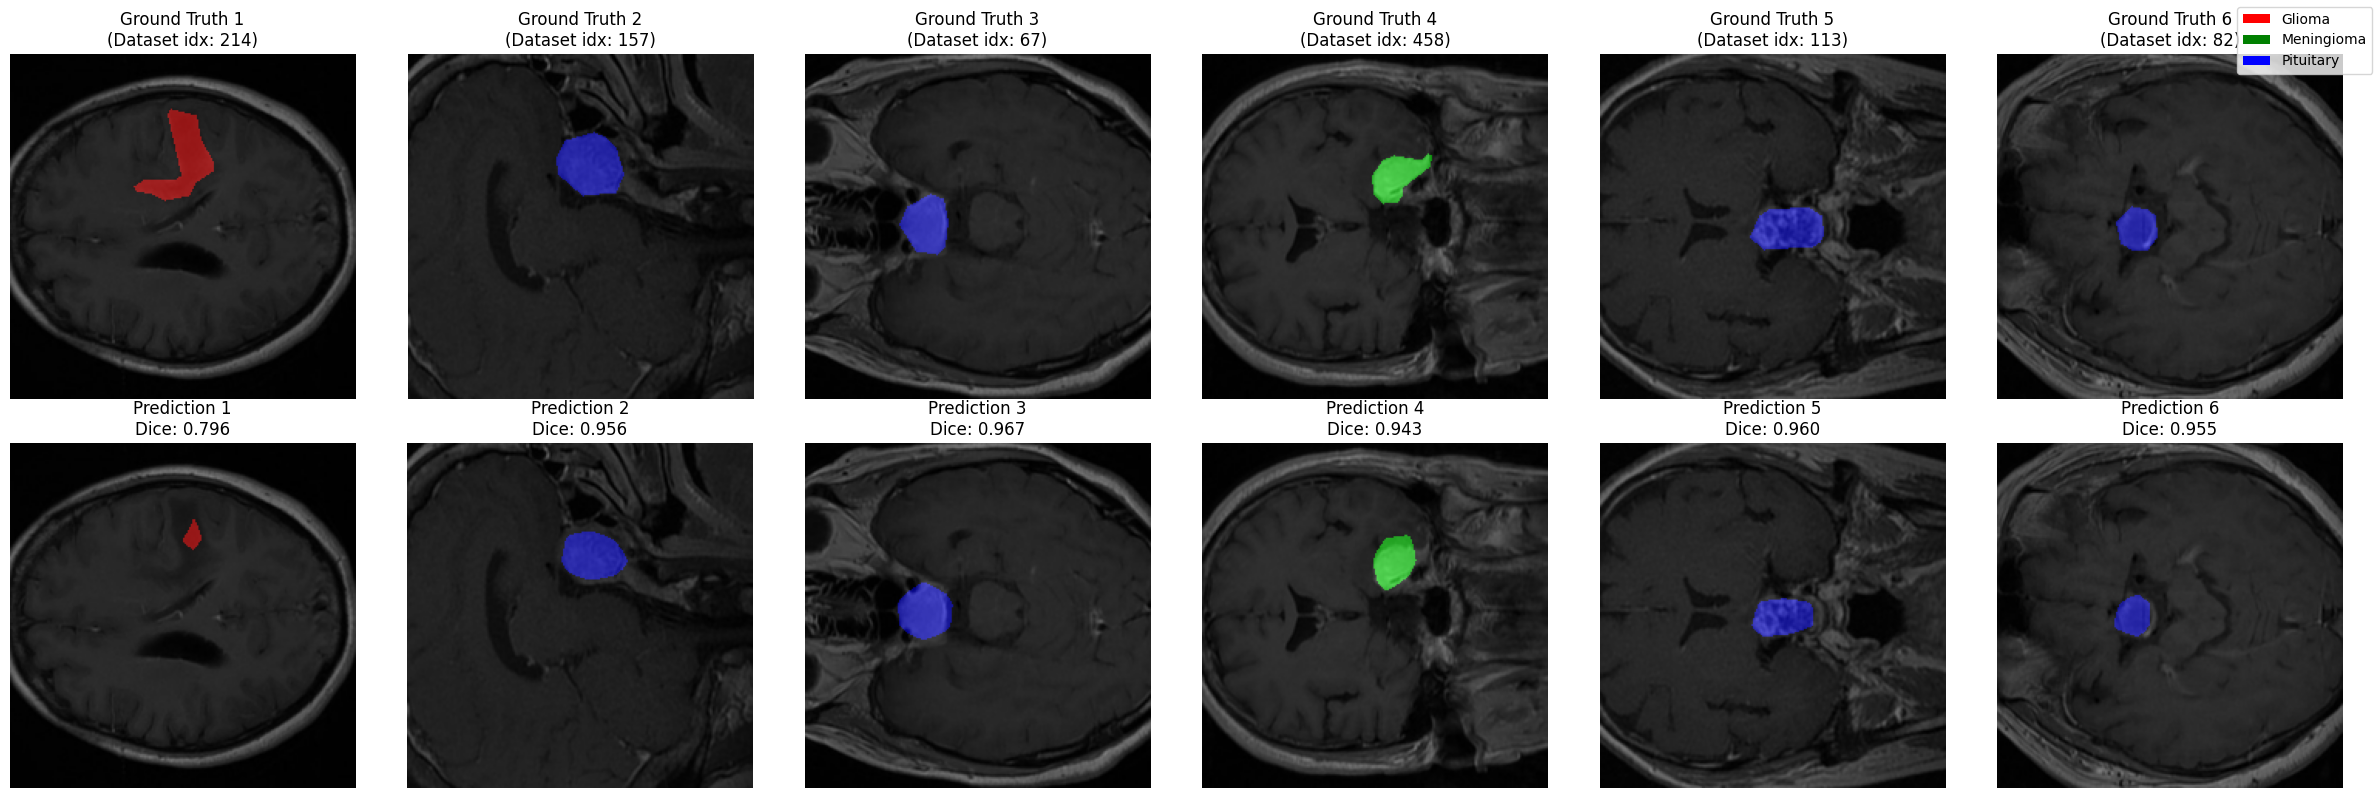

In [29]:
prediction_examples = visualize_validation_predictions_with_overlay(
    model=dinov2_segmentation_model,
    validation_dataloader=dinov2_validation_dataloader,
    device=device,
    max_examples=6,
    alpha=0.5,
)

📊 Randomly sampling 6 examples from 612 validation images...
Random Validation Samples: Ground Truth vs Prediction Overlays


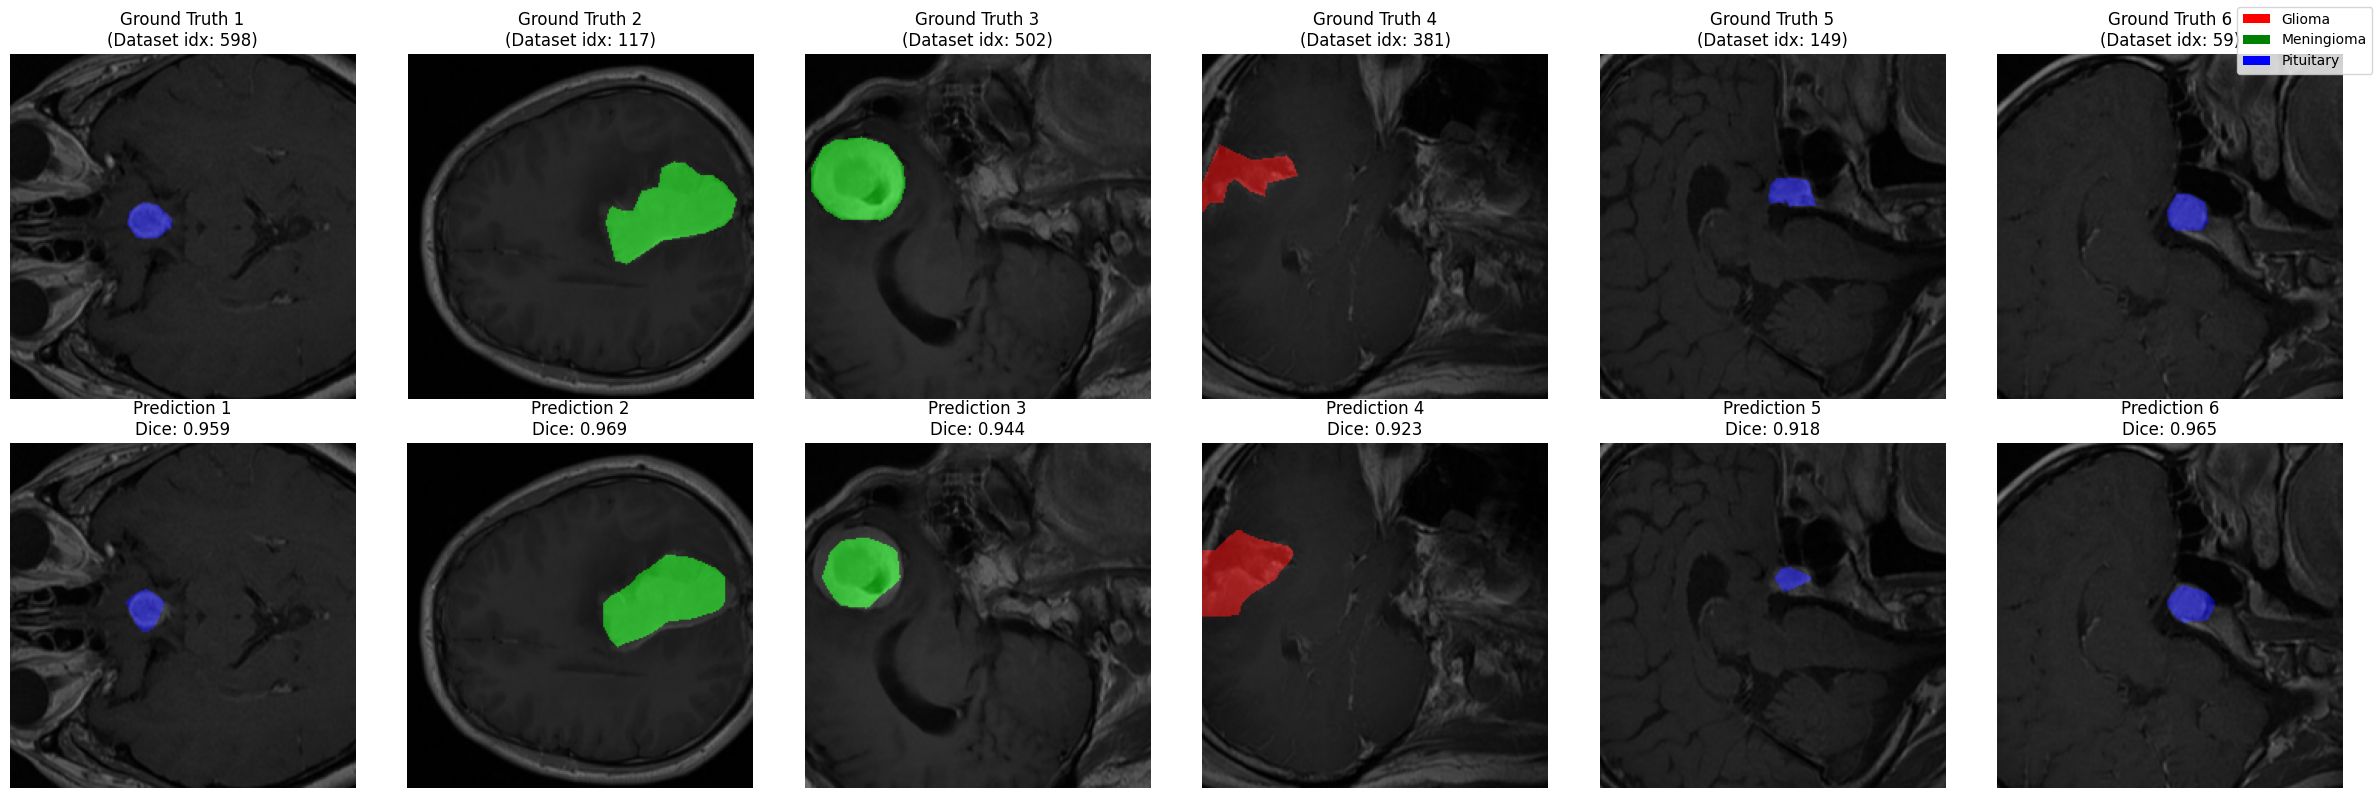

In [34]:
prediction_examples = visualize_validation_predictions_with_overlay(
    model=dinov3_segmentation_model,
    validation_dataloader=dinov3_validation_dataloader,
    device=device,
    max_examples=6,
    alpha=0.5,
)